In [71]:
import pandas as pd
import glob
import datetime
import os
import matplotlib.pyplot as plt
import itertools
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import normalize
from sklearn.utils.random import sample_without_replacement
import joblib
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from sklearn.impute import KNNImputer
np.random.seed(999)
if not os.path.exists('./model'):
    os.makedirs('./model')
if not os.path.exists('./ConfusionMatrix'):
    os.makedirs('./ConfusionMatrix')

Func of plotting ROC curve

In [4]:
plt.rcParams['savefig.dpi'] = 150 #图片像素
plt.rcParams['figure.dpi'] = 150 #分辨率
def plot_roc_curve(fpr, tpr, auc, model):
    plt.plot(fpr, tpr, color='orange', label='ROC_'+model)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve, AUC: {:3f}'.format(auc))
    plt.legend()
    plt.axis([0, 1, 0, 1])
    plt.show()
   

Loading data

In [43]:
X = pd.DataFrame([[i for i in range(10)] for j in range(100)])
X.columns = [str(i) for i in range(10)]
Y = pd.DataFrame([i%2 for i in range(100)])

Fillinf NaNs

In [44]:
X = X.interpolate(method='linear')
X = X.fillna(X.mean())
X = X.fillna(0)
X = X.fillna(method='ffill')
X = X.fillna(method='bfill')
X = X.fillna(-1)

# imputer = KNNImputer(n_neighbors=5, weights="distance")
# X = imputer.fit_transform(X)


Preprocess data imbalance issue

In [45]:
# RandomOverSampler, downsample, adasyn, smote
ros = RandomOverSampler(random_state=999)
X, Y = ros.fit_resample(X, Y)
ada = ADASYN(random_state=999)
X, Y = ada.fit_resample(X, Y)
sm = SMOTE(random_state=999)
X, Y = sm.fit_resample(X, Y)


a = sample_without_replacement(n_population = max(len(normal),len(abnormal)),n_samples = min(len(normal),len(abnormal)))
if len(abnormal)>len(normal):
    abnormal = abnormal.iloc[a]
else:,
     normal = normal.iloc[a]

Normalize data

In [46]:
# X = normalize(X)

split data, pca and some other works

In [47]:
np.random.seed(999)
x_train, x_test, y_train, y_test = train_test_split(X, Y, shuffle = True, test_size = 0.25)

classifier_model = []
classifier_accuracy = []
CM = []
AUC = []
fpr_tpr = []
pca = PCA()
pca.fit(X)
pca_input_data = pca.transform(X)
np.random.seed(999)
pca_x_train, pca_x_test, pca_y_train, pca_y_test = train_test_split(pca_input_data, Y, shuffle = True, test_size = 0.25)
joblib.dump(pca,'./model/pca.pkl')

c:\users\jacky lee\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


['./model/pca.pkl']

model training

c:\users\jacky lee\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


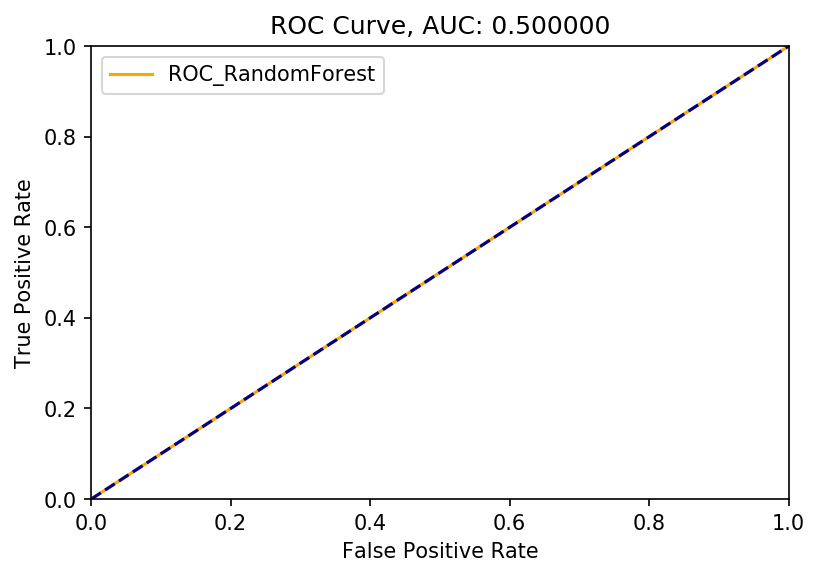

In [49]:
from sklearn.ensemble import RandomForestClassifier
classifier_model.append('RandomForest')
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
classifier_accuracy.append(rfc.score(x_test, y_test))
y_pred = rfc.predict(x_test)
CM.append(confusion_matrix(y_test, y_pred))
joblib.dump(rfc,'./model/RandomForest.pkl')
prob = rfc.predict_proba(x_test)[:,1]
auc = roc_auc_score(y_test, prob)
AUC.append(auc)
fpr, tpr, thresholds = roc_curve(y_test, prob)
fpr_tpr += [[fpr, tpr]]
plot_roc_curve(fpr, tpr, auc, 'RandomForest')

Feature importance

Feature ranking:
1. 0 0.000000
2. 1 0.000000
3. 2 0.000000
4. 3 0.000000
5. 4 0.000000
6. 5 0.000000
7. 6 0.000000
8. 7 0.000000
9. 8 0.000000
10. 9 0.000000


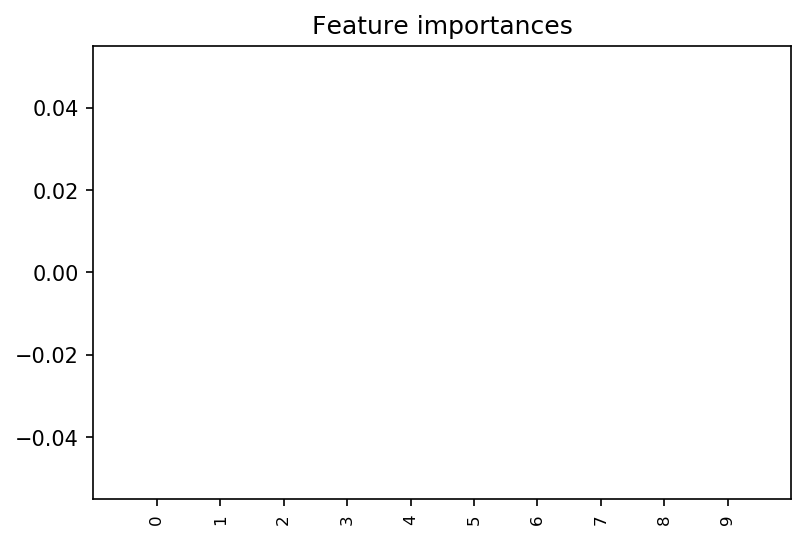

In [52]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("{}. {} {:4f}" .format(f + 1, x_train.columns[f], importances[indices[f]]))

# Plot the feature importances of the forest
# plt.figure()
plt.figure()
plt.title("Feature importances")
# plt.bar(range(x_train.shape[1]), importances[indices],
#        color="r", align="center")
plt.bar(range(10), importances[indices][0:10], align="center")
plt.xticks(range(10), x_train.columns[0:10],rotation=90,size=8)
plt.xlim([-1, 10])
plt.savefig(r'./feature.jpg')
plt.show()

c:\users\jacky lee\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


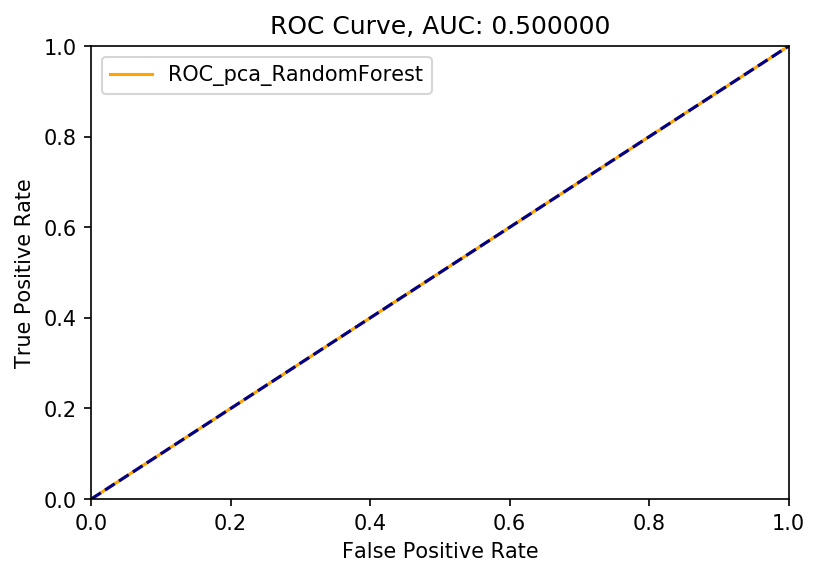

In [53]:
classifier_model.append('RandomForest with PCA')
rfc.fit(pca_x_train, pca_y_train)
classifier_accuracy.append(rfc.score(pca_x_test, pca_y_test))
y_pred = rfc.predict(pca_x_test)
CM.append(confusion_matrix(pca_y_test, y_pred))
joblib.dump(rfc,'./model/RandomForest_with_pca.pkl')
prob = rfc.predict_proba(pca_x_test)[:,1]
auc = roc_auc_score(pca_y_test, prob)
AUC.append(auc)
fpr, tpr, thresholds = roc_curve(pca_y_test, prob)
fpr_tpr += [[fpr, tpr]]
plot_roc_curve(fpr, tpr, auc, 'pca_RandomForest')

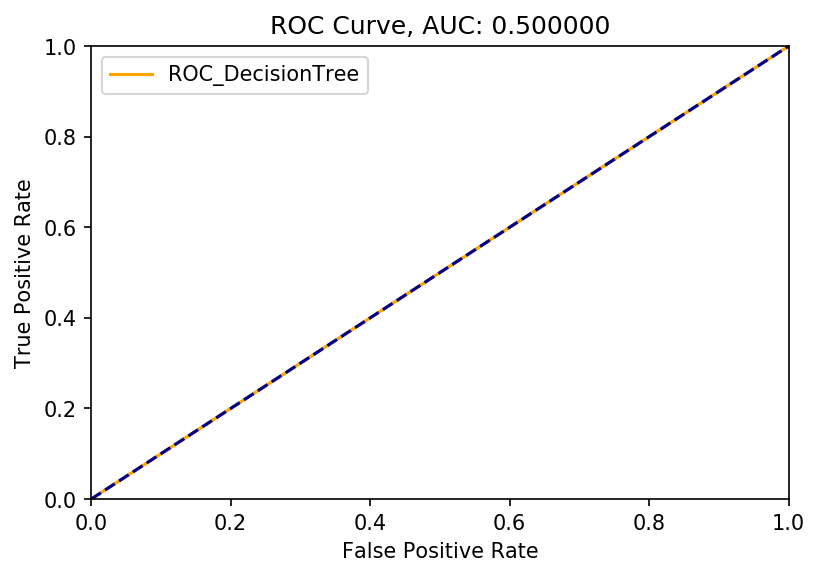

In [54]:
from sklearn.tree import DecisionTreeClassifier
classifier_model.append('DecisionTree')
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
classifier_accuracy.append(dtc.score(x_test, y_test))
y_pred = dtc.predict(x_test)
CM.append(confusion_matrix(y_test, y_pred))
joblib.dump(dtc,'./model/DecisionTree.pkl')
prob = dtc.predict_proba(x_test)[:,1]
auc = roc_auc_score(y_test, prob)
AUC.append(auc)
fpr, tpr, thresholds = roc_curve(y_test, prob)
fpr_tpr += [[fpr, tpr]]
plot_roc_curve(fpr, tpr, auc, 'DecisionTree')

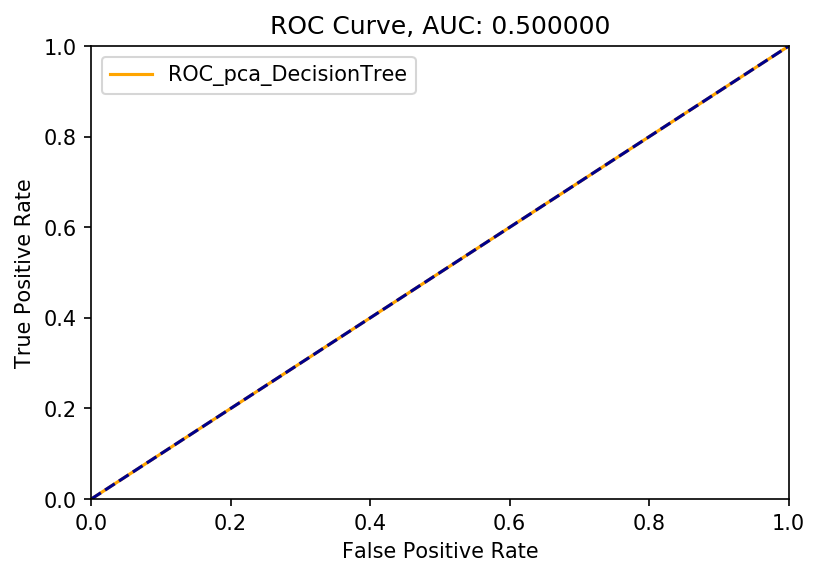

In [55]:
classifier_model.append('DecisionTree with PCA')
dtc.fit(pca_x_train, pca_y_train)
classifier_accuracy.append(dtc.score(pca_x_test, pca_y_test))
y_pred = dtc.predict(pca_x_test)
CM.append(confusion_matrix(pca_y_test, y_pred))
joblib.dump(dtc,'./model/DecisionTree_with_pca.pkl')
prob = dtc.predict_proba(pca_x_test)[:,1]
auc = roc_auc_score(pca_y_test, prob)
AUC.append(auc)
fpr, tpr, thresholds = roc_curve(pca_y_test, prob)
fpr_tpr += [[fpr, tpr]]
plot_roc_curve(fpr, tpr, auc, 'pca_DecisionTree')

c:\users\jacky lee\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
c:\users\jacky lee\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


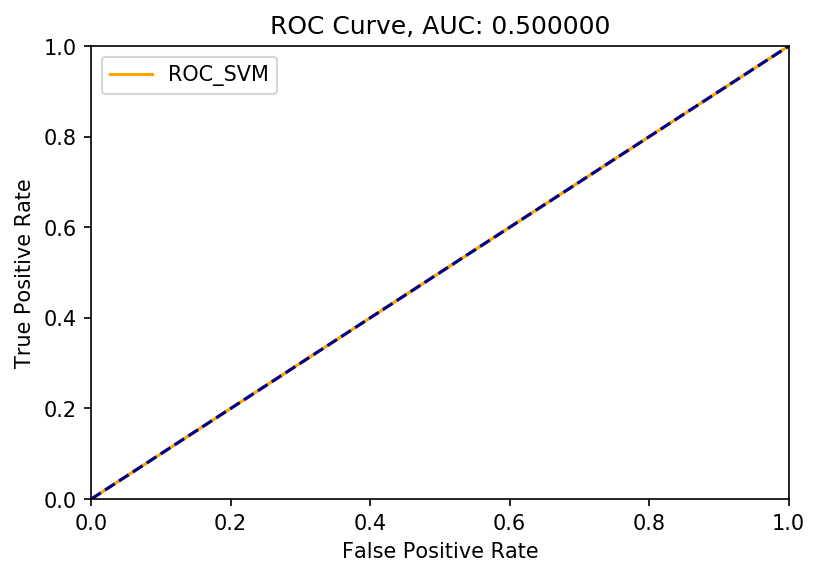

In [56]:
from sklearn.svm import LinearSVC
classifier_model.append('SVM')
svm = LinearSVC()#random_state=0, tol=1e-5
svm.fit(x_train, y_train)
classifier_accuracy.append(svm.score(x_test, y_test))
y_pred = svm.predict(x_test)
CM.append(confusion_matrix(y_test, y_pred))
joblib.dump(svm,'./model/svm.pkl')
# prob = svm.predict_proba(x_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
AUC.append(auc)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
fpr_tpr += [[fpr, tpr]]
plot_roc_curve(fpr, tpr, auc, 'SVM')

c:\users\jacky lee\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


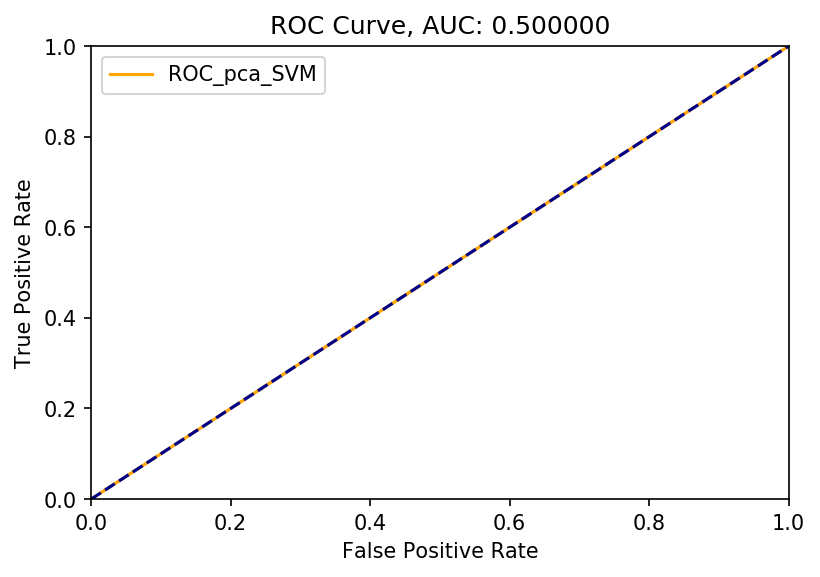

In [57]:
classifier_model.append('SVM with PCA')
svm.fit(pca_x_train, pca_y_train)
classifier_accuracy.append(svm.score(pca_x_test, pca_y_test))
y_pred = svm.predict(pca_x_test)
CM.append(confusion_matrix(pca_y_test, y_pred))
joblib.dump(svm,'./model/svm_with_pca.pkl')
# prob = svm.predict_proba(pca_x_test)[:,1]
auc = roc_auc_score(pca_y_test, y_pred)
AUC.append(auc)
fpr, tpr, thresholds = roc_curve(pca_y_test, y_pred)
fpr_tpr += [[fpr, tpr]]
plot_roc_curve(fpr, tpr, auc, 'pca_SVM')

c:\users\jacky lee\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


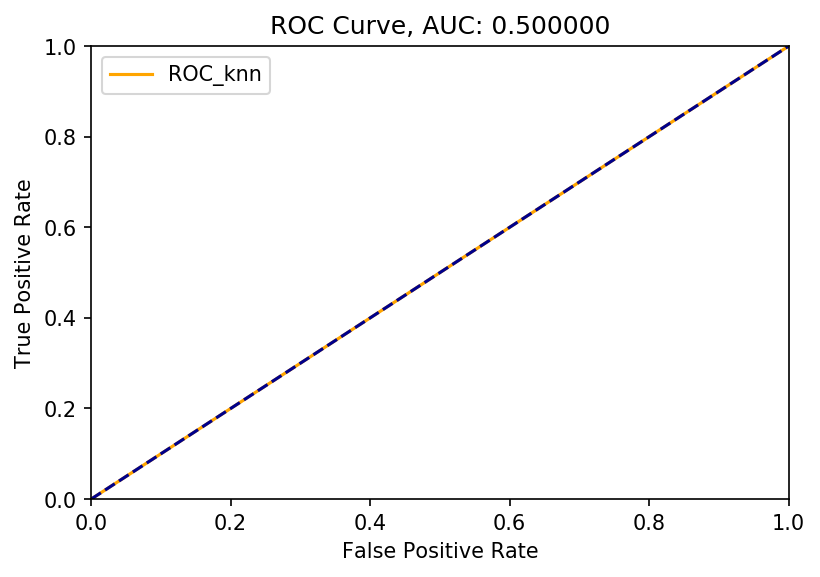

In [58]:
from sklearn.neighbors import KNeighborsClassifier
classifier_model.append('KNN')
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)
classifier_accuracy.append(knn.score(x_test, y_test))
y_pred = knn.predict(x_test)
CM.append(confusion_matrix(y_test, y_pred))
joblib.dump(knn,'./model/knn.pkl')
prob = knn.predict_proba(x_test)[:,1]
auc = roc_auc_score(y_test, prob)
AUC.append(auc)
fpr, tpr, thresholds = roc_curve(y_test, prob)
fpr_tpr += [[fpr, tpr]]
plot_roc_curve(fpr, tpr, auc, 'knn')

c:\users\jacky lee\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


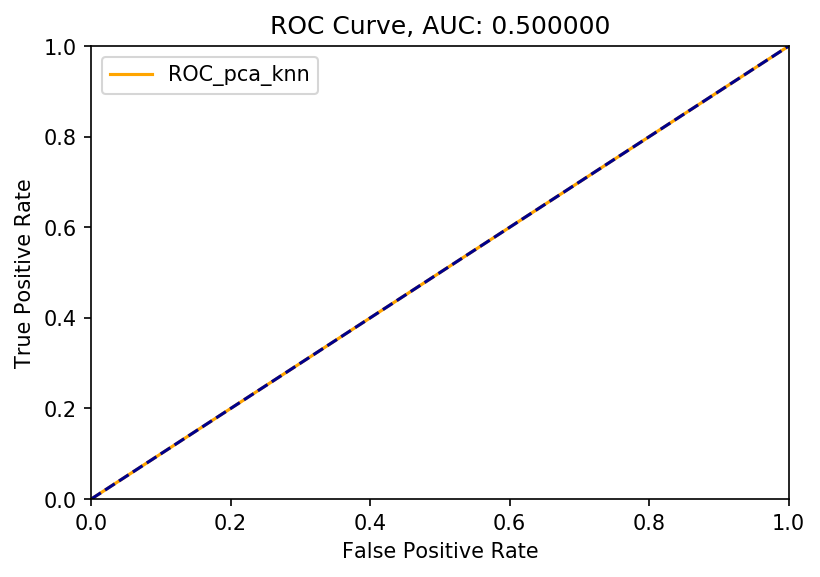

In [59]:
classifier_model.append('KNN with PCA')
knn.fit(pca_x_train, pca_y_train)
classifier_accuracy.append(knn.score(pca_x_test, pca_y_test))
y_pred = knn.predict(pca_x_test)
CM.append(confusion_matrix(pca_y_test, y_pred))
joblib.dump(knn,'./model/knn_with_pca.pkl')
prob = knn.predict_proba(pca_x_test)[:,1]
auc = roc_auc_score(pca_y_test, prob)
AUC.append(auc)
fpr, tpr, thresholds = roc_curve(pca_y_test, prob)
fpr_tpr += [[fpr, tpr]]
plot_roc_curve(fpr, tpr, auc, 'pca_knn')

c:\users\jacky lee\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


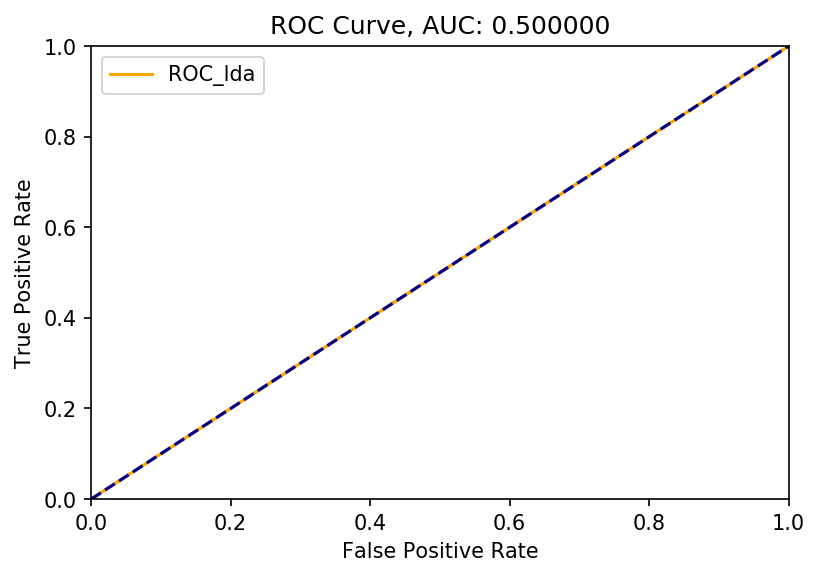

In [60]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
classifier_model.append('LDA')
lda = LinearDiscriminantAnalysis(solver = 'lsqr',shrinkage ='auto')
lda.fit(x_train, y_train)
classifier_accuracy.append(lda.score(x_test, y_test))
y_pred = lda.predict(x_test)
CM.append(confusion_matrix(y_test, y_pred))
joblib.dump(lda,'./model/lda.pkl')
prob = lda.predict_proba(x_test)[:,1]
auc = roc_auc_score(y_test, prob)
AUC.append(auc)
fpr, tpr, thresholds = roc_curve(y_test, prob)
fpr_tpr += [[fpr, tpr]]
plot_roc_curve(fpr, tpr, auc, 'lda')

c:\users\jacky lee\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


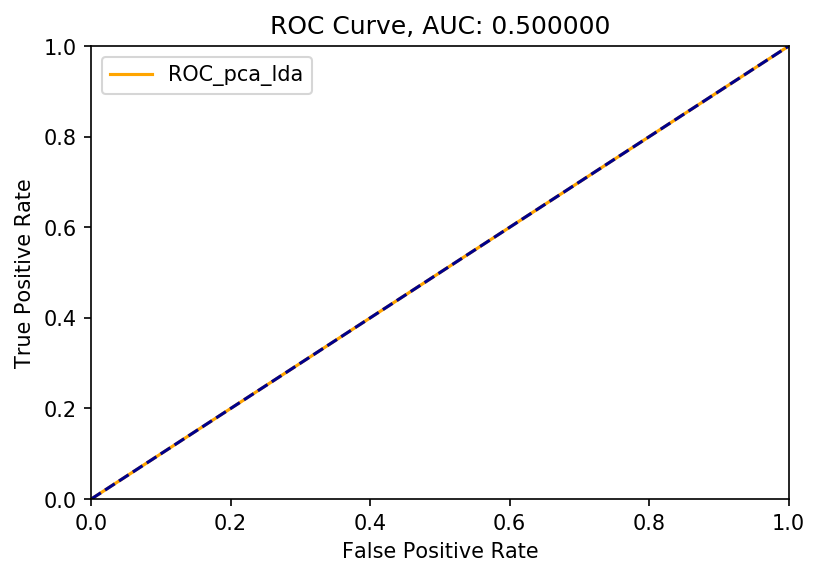

In [61]:
classifier_model.append('LDA with PCA')
lda.fit(pca_x_train, pca_y_train)
classifier_accuracy.append(lda.score(pca_x_test, pca_y_test))
y_pred = lda.predict(pca_x_test)
CM.append(confusion_matrix(pca_y_test, y_pred))
#plot_confusion_matrix(pca_y_test, y_pred, ['alive', 'death'])
joblib.dump(lda,'./model/lda_with_pca.pkl')
prob = lda.predict_proba(pca_x_test)[:,1]
auc = roc_auc_score(pca_y_test, prob)
AUC.append(auc)
fpr, tpr, thresholds = roc_curve(pca_y_test, prob)
fpr_tpr += [[fpr, tpr]]
plot_roc_curve(fpr, tpr, auc, 'pca_lda')

c:\users\jacky lee\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


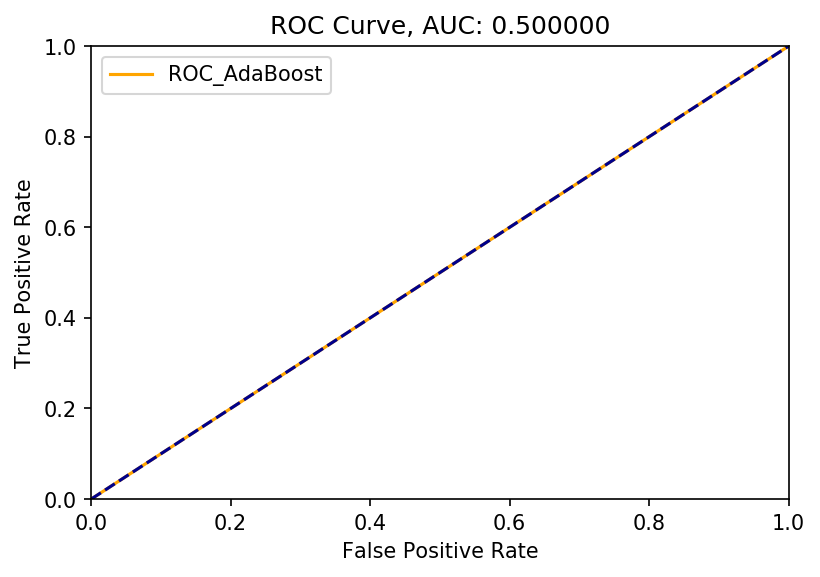

In [62]:
from sklearn.ensemble import AdaBoostClassifier
classifier_model.append('AdaBoost')
AdaBoost = AdaBoostClassifier()
AdaBoost.fit(x_train, y_train)
classifier_accuracy.append(AdaBoost.score(x_test, y_test))
y_pred = AdaBoost.predict(x_test)
CM.append(confusion_matrix(y_test, y_pred))
joblib.dump(AdaBoost,'./model/AdaBoost.pkl')
prob = AdaBoost.predict_proba(x_test)[:,1]
auc = roc_auc_score(y_test, prob)
AUC.append(auc)
fpr, tpr, thresholds = roc_curve(y_test, prob)
fpr_tpr += [[fpr, tpr]]
plot_roc_curve(fpr, tpr, auc, 'AdaBoost')

c:\users\jacky lee\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


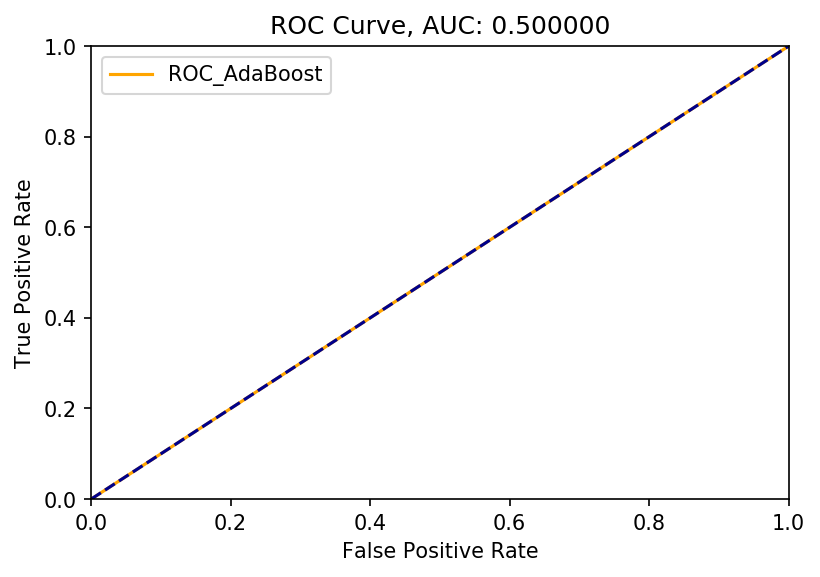

In [63]:
classifier_model.append('AdaBoost with PCA')
AdaBoost.fit(pca_x_train, pca_y_train)
classifier_accuracy.append(AdaBoost.score(pca_x_test, pca_y_test))
y_pred = AdaBoost.predict(pca_x_test)
CM.append(confusion_matrix(pca_y_test, y_pred))
#plot_confusion_matrix(pca_y_test, y_pred, ['alive', 'death'])
joblib.dump(AdaBoost,'./model/AdaBoost_with_pca.pkl')
prob = AdaBoost.predict_proba(pca_x_test)[:,1]
auc = roc_auc_score(pca_y_test, prob)
AUC.append(auc)
fpr, tpr, thresholds = roc_curve(pca_y_test, prob)
fpr_tpr += [[fpr, tpr]]
plot_roc_curve(fpr, tpr, auc, 'AdaBoost')

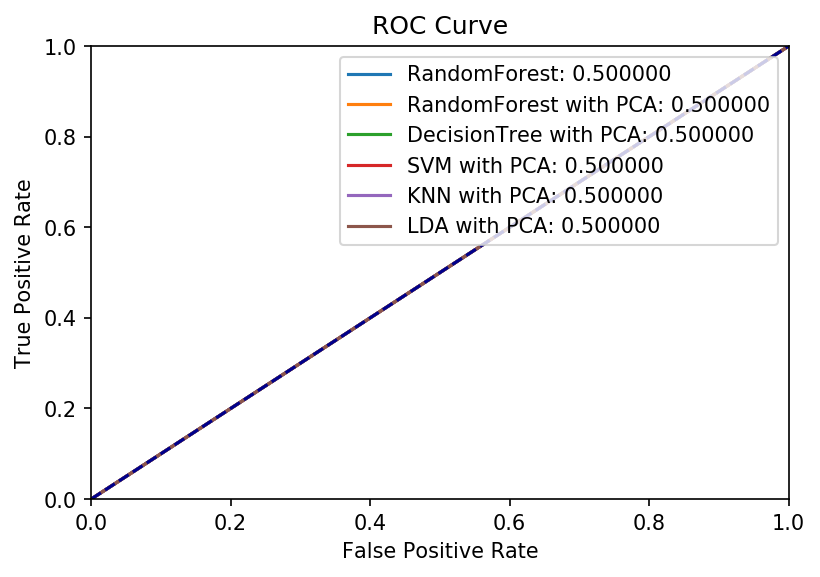

In [64]:
plt.figure()
for idx in range(6):
    fpr, tpr = fpr_tpr[idx*2][0], fpr_tpr[idx*2][1]
    plt.plot(fpr, tpr, label=classifier_model[idx*2] + ': {0:4f}'.format(AUC[idx*2]))
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.axis([0, 1, 0, 1])
plt.savefig('ROC.png')
plt.show()

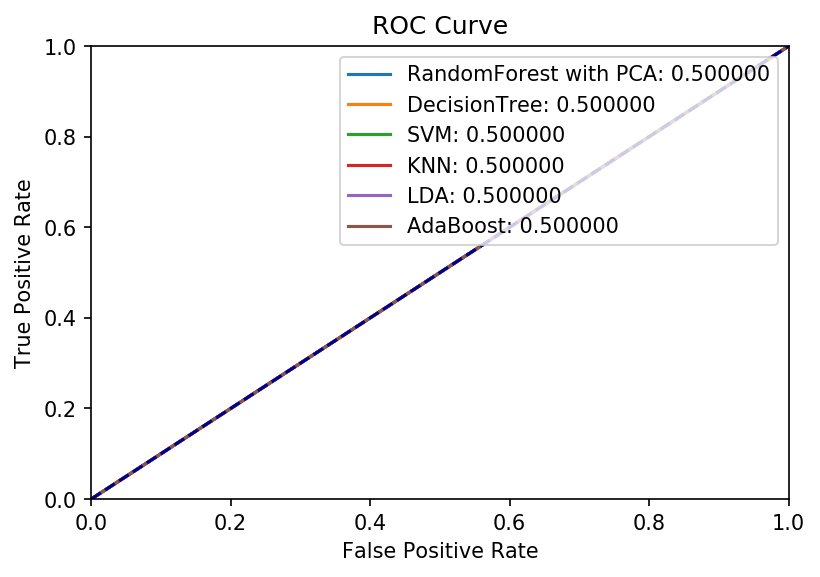

In [65]:
plt.figure()
for idx in range(6):
    fpr, tpr = fpr_tpr[idx*2+1][0], fpr_tpr[idx*2+1][1]
    plt.plot(fpr, tpr, label=classifier_model[idx*2+1] + ': {0:4f}'.format(AUC[idx*2+1]))
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.axis([0, 1, 0, 1])
plt.savefig('ROC_PCA.png')
plt.show()

show results

In [66]:
result = {}
result = {
    'model':classifier_model,
    'accuracy':classifier_accuracy,
    'confusion matrix':CM,
    'AUROC': AUC
}
result = pd.DataFrame(result)
result['Specificity'] = result['confusion matrix'].apply(lambda x: x[0,0]/(x[0,0]+x[0,1]))
result['Sensitivity'] = result['confusion matrix'].apply(lambda x: x[1,1]/(x[1,1]+x[1,0]))
result['Precision'] = result['confusion matrix'].apply(lambda x: x[1,1]/(x[1,1]+x[0,1]))
result['F1_score'] = 2 / ((1/result['Sensitivity'])+(1/result['Precision']))
result

,model,accuracy,confusion matrix,AUROC,Specificity,Sensitivity,Precision,F1_score
0,RandomForest,0.4,"[[0, 15], [0, 10]]",0.5,0.0,1.0,0.4,0.571429
1,RandomForest with PCA,0.4,"[[0, 15], [0, 10]]",0.5,0.0,1.0,0.4,0.571429
2,RandomForest with PCA,0.4,"[[0, 15], [0, 10]]",0.5,0.0,1.0,0.4,0.571429
3,DecisionTree,0.4,"[[0, 15], [0, 10]]",0.5,0.0,1.0,0.4,0.571429
4,DecisionTree with PCA,0.4,"[[0, 15], [0, 10]]",0.5,0.0,1.0,0.4,0.571429
5,SVM,0.4,"[[0, 15], [0, 10]]",0.5,0.0,1.0,0.4,0.571429
6,SVM with PCA,0.4,"[[0, 15], [0, 10]]",0.5,0.0,1.0,0.4,0.571429
7,KNN,0.6,"[[15, 0], [10, 0]]",0.5,1.0,0.0,NaN,NaN
8,KNN with PCA,0.6,"[[15, 0], [10, 0]]",0.5,1.0,0.0,NaN,NaN
9,LDA,0.4,"[[0, 15], [0, 10]]",0.5,0.0,1.0,0.4,0.571429


show confusion matrix

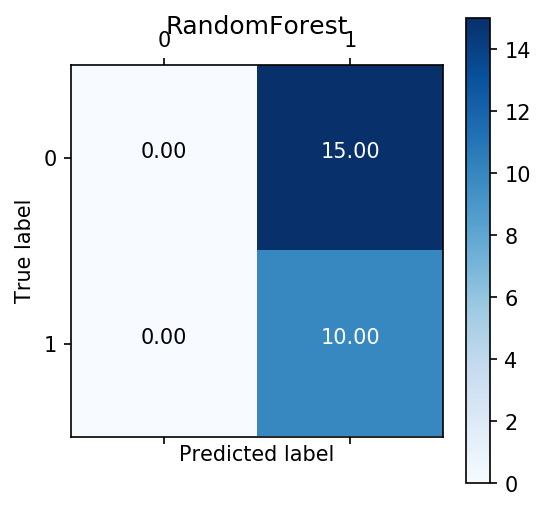

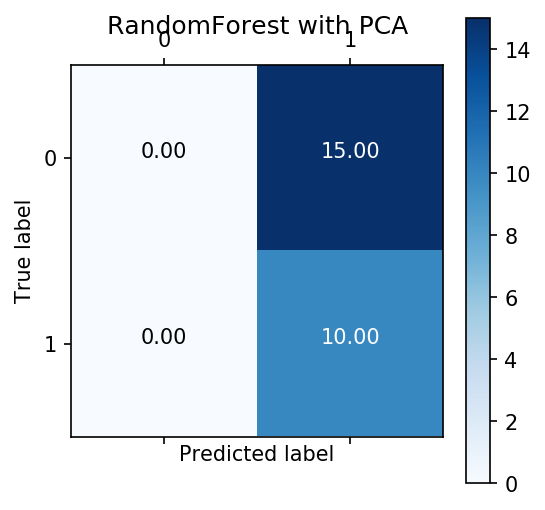

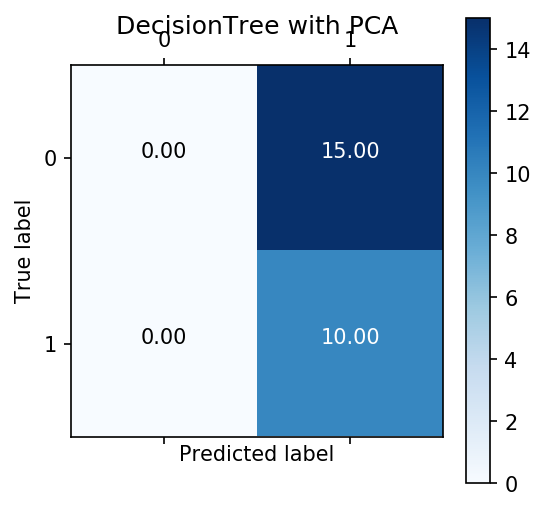

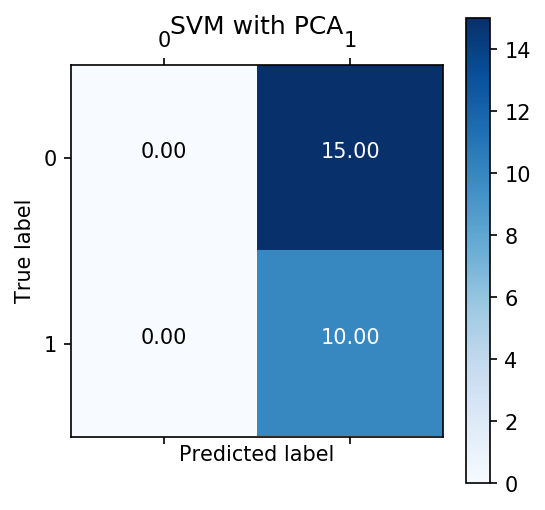

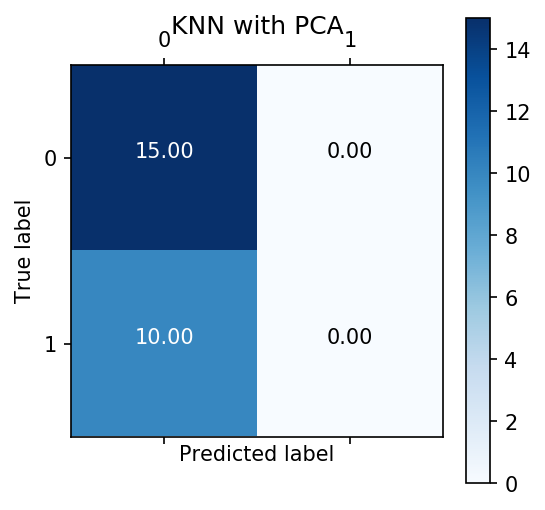

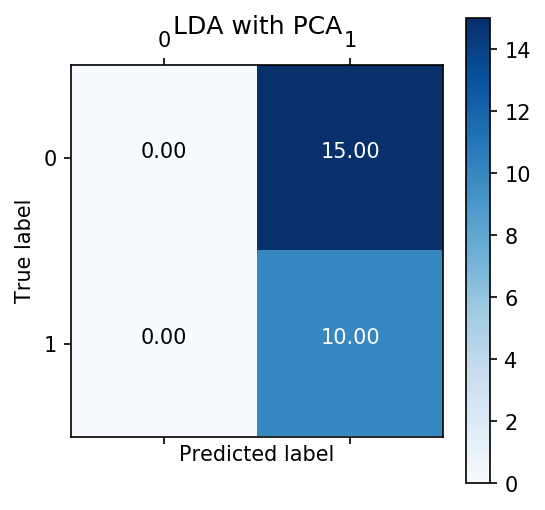

In [69]:
classes = ['Not AE', 'AE']
plt.rcParams['savefig.dpi'] = 150 #图片像素
plt.rcParams['figure.dpi'] = 150 #分辨率
for idx in range(6):
    cm = result['confusion matrix'][idx*2]
    plt.matshow(cm, cmap=plt.cm.Blues)
    plt.title(result['model'][idx*2])
    plt.colorbar()
    tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(os.path.join('ConfusionMatrix',result['model'][idx*2]+'.png'))
    plt.show()
    

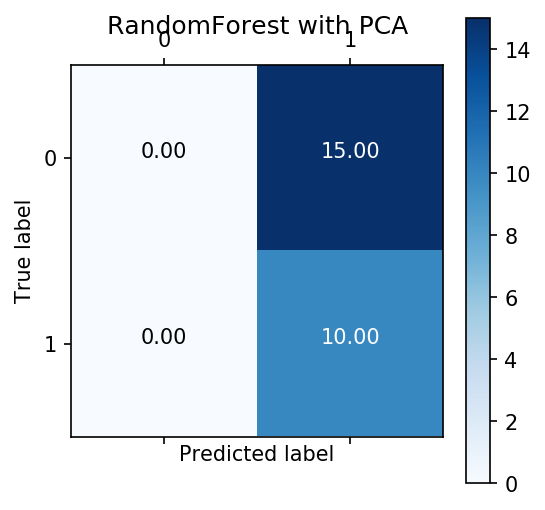

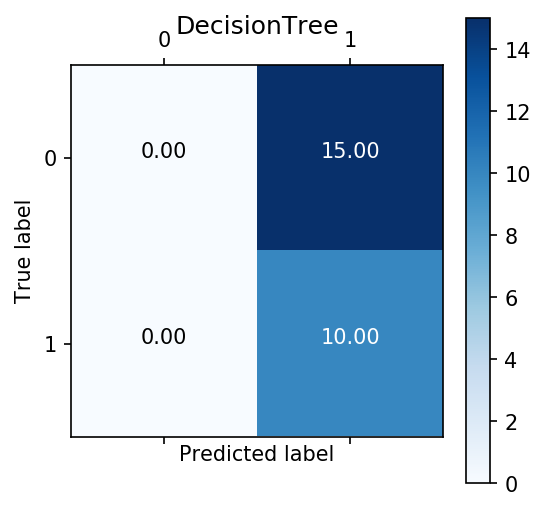

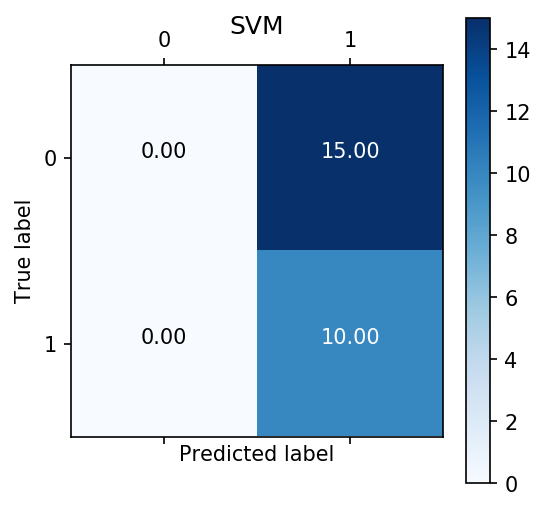

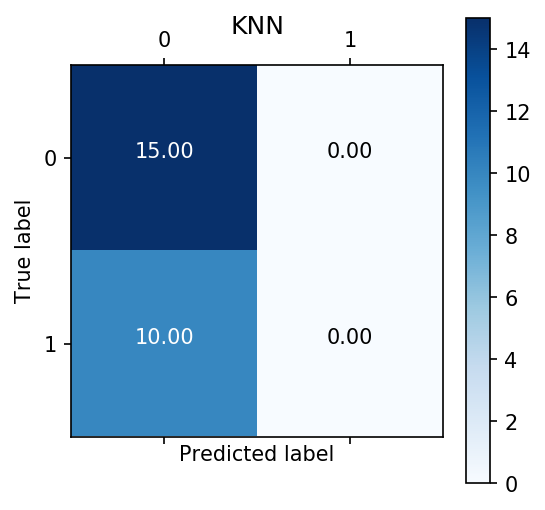

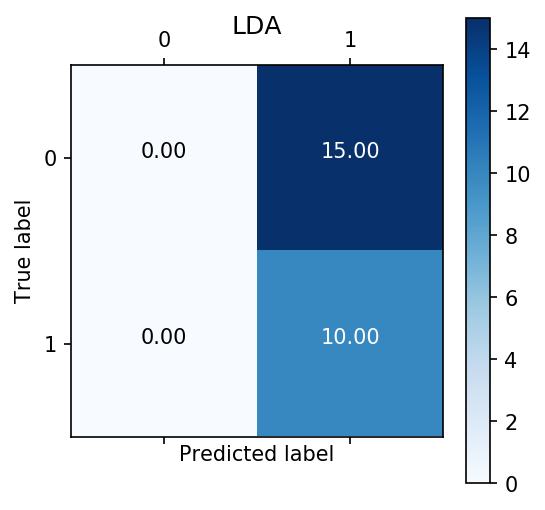

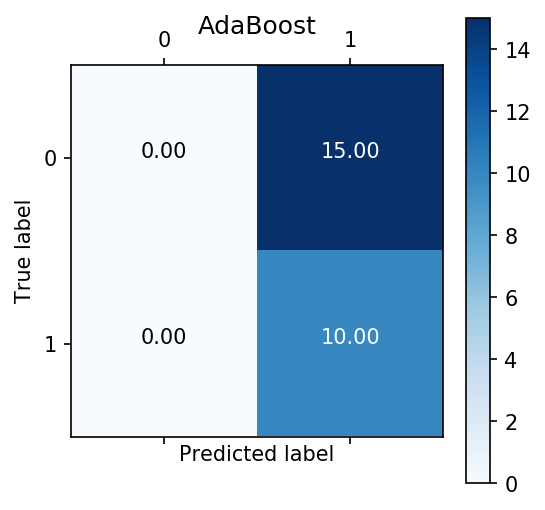

In [70]:
classes = ['Not AE', 'AE']
plt.rcParams['savefig.dpi'] = 150 #图片像素
plt.rcParams['figure.dpi'] = 150 #分辨率
for idx in range(6):
    cm = result['confusion matrix'][idx*2+1]
    plt.matshow(cm, cmap=plt.cm.Blues)
    plt.title(result['model'][idx*2+1])
    plt.colorbar()
    tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(os.path.join('ConfusionMatrix',result['model'][idx*2+1]+'.png'))
    plt.show()

In [ ]:
# # import matplotlib.pyplot as plt
# for feature in sheet_1:
#     data = [sheet_1[sheet_1['AE_近日有無急性惡化發作']==0].dropna().astype(str).values,sheet_1[sheet_1['AE_近日有無急性惡化發作']==1].dropna().astype(str).values]
#     plt.hist(data, 10, histtype='bar', density = True)
#     plt.title('hist_' + feature)

#     plt.tight_layout()
#     plt.show()
# # ax = ae_true_normal.plot.hist(bins=12, alpha=0.5)